In [111]:
import pandas as pd
import numpy as np
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV, TimeSeriesSplit
from sklearn.linear_model import LassoCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, r2_score, mean_squared_error
import matplotlib.pyplot as plt
import seaborn as sns

In [112]:
# Configurações de visualização
%matplotlib inline
sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (12, 6)

# --- Carregar o Dataset ---
# Usamos index_col='date' e parse_dates=True para que o Pandas
# entenda nosso dataset como uma série temporal.

FILE_NAME = '../data/dataset-final-final.csv'

try:
    df = pd.read_csv(FILE_NAME, index_col='date', parse_dates=True)
except FileNotFoundError:
    print(f"Erro: Arquivo '{FILE_NAME}' não encontrado.")
    # Se der erro, pare aqui e verifique o nome do arquivo.
    raise

print(f"Dataset '{FILE_NAME}' carregado com sucesso.")
print(f"Dimensão: {df.shape}")
print("\nPrimeiras 5 linhas:")

# Verificar se as colunas necessárias do Compound estão presentes
required_cols = ['total_deposit_usd', 'deposit_apy', 'utilization_rate']
if not all(col in df.columns for col in required_cols):
    print("\nERRO: Colunas do Compound não encontradas. Verifique seu merge.")
else:
    print("\nColunas do Compound validadas com sucesso.")

Dataset '../data/dataset-final-final.csv' carregado com sucesso.
Dimensão: (1002, 32)

Primeiras 5 linhas:

Colunas do Compound validadas com sucesso.


In [113]:
df.head()

,Y_Aave_APY,X_Aave_Utilization,totalValueLockedUSD,Y_SOFR,X_USDC_Depeg_Risk,X_BTC_Price,X_ETH_Price,X_VIX,X_DGS2,X_Gas_Price_Gwei,...,total_tvl_aave,total_tvl_compound,total_tvl_defi,apy_aave,apy_compound,DeFi_APY_Ponderado,Y_Target_Spread_Ponderado,Spread_Aave_Compound,compound_utilization_rate,delta_total_defi_tvl_7d
date,,,,,,,,,,,,,,,,,,,,,
2023-02-10,1.065206,0.516046,2.954084e+07,4.55,0.395367,21629.58,1513.90,20.53,4.50,29.368859,...,2.954084e+07,1.530275e+08,1.825683e+08,1.065206,2.469392,2.242184,-2.307816,-1.404186,75.981277,0.047703
2023-02-11,1.351110,0.581190,2.983011e+07,4.55,0.366080,21857.51,1538.26,20.53,4.50,21.415378,...,2.983011e+07,1.531180e+08,1.829482e+08,1.351110,2.407529,2.235278,-2.314722,-1.056419,74.077824,0.041050
2023-02-12,1.477193,0.607706,2.901072e+07,4.55,0.375003,21784.08,1514.41,20.53,4.50,21.067639,...,2.901072e+07,1.534786e+08,1.824893e+08,1.477193,2.394697,2.248840,-2.301160,-0.917504,73.682817,0.033322
2023-02-13,1.234612,0.555573,3.404628e+07,4.55,0.415355,21786.33,1506.71,20.34,4.52,29.595632,...,3.404628e+07,1.532760e+08,1.873223e+08,1.234612,2.199709,2.024301,-2.525699,-0.965098,67.678167,0.041849
2023-02-14,1.718342,0.655439,3.610464e+07,4.55,0.387936,22193.69,1557.20,18.91,4.60,64.056071,...,3.610464e+07,1.535504e+08,1.896550e+08,1.718342,2.200525,2.108732,-2.441268,-0.482184,67.708469,0.045900


[]

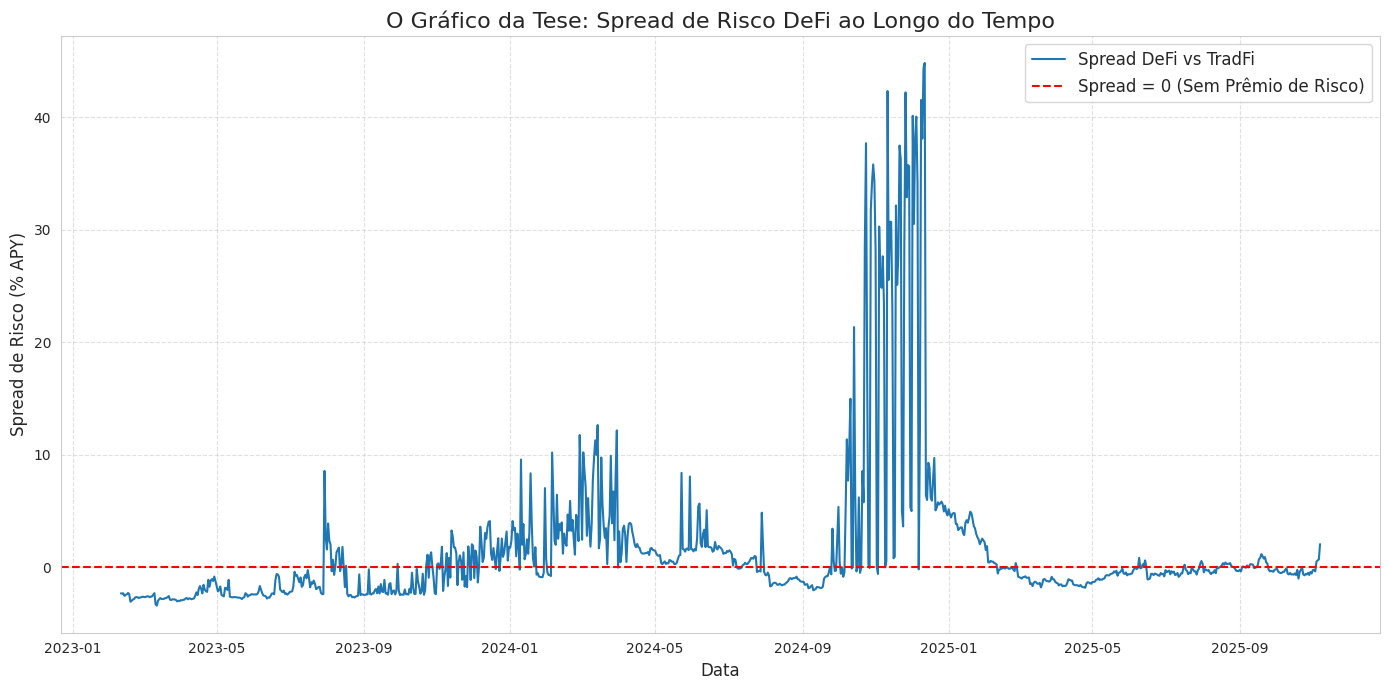

In [114]:
# --- 3. Gerar "O Gráfico da Tese" (Plot de Série Temporal) ---
plt.figure(figsize=(14, 7))
ax = sns.lineplot(x=df.index, y=df['Y_Target_Spread_Ponderado'], label='Spread DeFi vs TradFi')

# Adicionar uma linha de base em 0
ax.axhline(0, ls='--', color='red', lw=1.5, label='Spread = 0 (Sem Prêmio de Risco)')

# Melhorar a formatação
plt.title('O Gráfico da Tese: Spread de Risco DeFi ao Longo do Tempo', fontsize=16)
plt.ylabel('Spread de Risco (% APY)', fontsize=12)
plt.xlabel('Data', fontsize=12)
plt.legend(fontsize=12)
plt.grid(True, linestyle='--', alpha=0.6)
plt.tight_layout()

# Plotar o gráfico
plt.plot()


In [115]:
# Bloco 2: Engenharia de Features (Alvo Ponderado e Features de Cluster)

print("Iniciando Engenharia de Features...")

# --- 1. Criar o Alvo Ponderado (y) ---
# Usamos os TVLs (totalValueLockedUSD e total_deposit_usd) como pesos.

# Pesos (TVLs)
tvl_aave = df['totalValueLockedUSD']
tvl_compound = df['total_deposit_usd']
total_tvl_defi = tvl_aave + tvl_compound

# APYs
apy_aave = df['Y_Aave_APY']
apy_compound = df['deposit_apy']

# Cálculo do APY Ponderado
df['DeFi_APY_Ponderado'] = ((apy_aave * tvl_aave) + (apy_compound * tvl_compound)) / total_tvl_defi

# Cálculo do Novo Alvo (Spread Ponderado)
df['Y_Target_Spread_Ponderado'] = df['DeFi_APY_Ponderado'] - df['Y_SOFR']
print("Novo alvo 'Y_Target_Spread_Ponderado' criado.")

# --- 2. Criar Novas Features de Clusterização (X) ---
# O 'X_' no início ajuda a identificar features.

# Feature 1: Spread Interno DeFi (Aave vs Compound)
df['X_Spread_Aave_Compound'] = apy_aave - apy_compound

# Feature 2: Variação % do TVL DeFi (Fluxo de Capital em 7 dias)
df['X_Delta_TVL_DeFi_7D_pct'] = total_tvl_defi.pct_change(7)

# Feature 3: Renomear a utilização do Compound para o padrão 'X_'
df['X_Compound_Utilization'] = df['utilization_rate']

# --- 3. Limpeza Pós-Engenharia ---
# A feature 'X_Delta_TVL_DeFi_7D_pct' criou NaNs nas primeiras 7 linhas.
# Vamos removê-los para ter um dataset 100% limpo para modelagem.
df_model = df.dropna()

print("Novas features 'X_' para clusterização criadas.")
print(f"Dimensão final do dataset (pós-NaN drop): {df_model.shape}")


# É uma boa prática salvar este dataset final
df_model.to_csv('dataset_para_modelagem.csv')
print("Dataset final 'dataset_para_modelagem.csv' salvo.")

Iniciando Engenharia de Features...
Novo alvo 'Y_Target_Spread_Ponderado' criado.
Novas features 'X_' para clusterização criadas.
Dimensão final do dataset (pós-NaN drop): (995, 35)
Dataset final 'dataset_para_modelagem.csv' salvo.


In [116]:
# Bloco 3: Definição e Seleção de Features (X) e Alvo (y)

# 1. Defina sua variável alvo (y)
TARGET_COLUMN = 'Y_Target_Spread_Ponderado'
y = df_model[TARGET_COLUMN]


# 2. Selecione as features para o modelo (X)
# Esta é a etapa de "Feature Selection"
# Inclua suas features antigas + as novas que criamos
FEATURE_COLUMNS = [
    # --- Features Antigas (TradFi + Aave) ---
    'X_Aave_Utilization',
    'X_USDC_Depeg_Risk',
    # 'X_BTC_Price',  # Preços absolutos podem ser ruins para clusterização
    # 'X_ETH_Price',
    'X_VIX',
    'X_DGS2',
    'X_Gas_Price_Gwei',
    'X_ETH_Returns',
    'X_ETH_Vol_7D',
    'X_BTC_Returns',
    'X_BTC_Vol_7D',
    'X_Gas_MA_7D',
    'X_VIX_Pct_Change',

    # --- NOVAS FEATURES (Compound + Mercado) ---
    'X_Compound_Utilization',   # Stress/Demanda no Compound
    'X_Spread_Aave_Compound',   # Fricção interna do DeFi
    'X_Delta_TVL_DeFi_7D_pct' # Fluxo de Capital/Momentum
]

# Garantir que estamos usando apenas colunas que realmente existem
features_existentes = [col for col in FEATURE_COLUMNS if col in df_model.columns]
X = df_model[features_existentes]

print(f"Total de features selecionadas para X: {len(features_existentes)}")

# 3. Padronizar (Standardize) as features
# O KMeans é sensível à escala, então este passo é OBRIGATÓRIO.
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Converter de volta para DataFrame para facilitar a análise
X_scaled = pd.DataFrame(X_scaled, columns=X.columns, index=X.index)

Total de features selecionadas para X: 14


In [117]:
# Bloco 4: Divisão Treino/Teste e Clusterização (Fit no Treino)

# 1. Definir o ponto de corte para treino/teste (Split Temporal)
# Usando 80% dos dados para treino, 20% para teste
split_index = int(len(df_model) * 0.8)

# --- Dividir TODOS os dataframes ---

# Dados padronizados (para KMeans)
X_train_scaled = X_scaled.iloc[:split_index]
X_test_scaled = X_scaled.iloc[split_index:]

# Dados brutos (para o Lasso)
X_raw = df_model[features_existentes] # Re-selecionar do df_model
X_train_raw = X_raw.iloc[:split_index]
X_test_raw = X_raw.iloc[split_index:]

# Alvo (y)
y_train = y.iloc[:split_index]
y_test = y.iloc[split_index:]

# DataFrames completos (para análise e plots)
df_train = df_model.iloc[:split_index].copy()
df_test = df_model.iloc[split_index:].copy()

print(f"Dados divididos: {len(df_train)} treino, {len(df_test)} teste.")
print(f"Data de corte: {df_test.index[0]}")

# 2. Treinar o modelo KMeans (APENAS NO TREINO)
N_CLUSTERS = 3 # 3 regimes (Calmo, Stress, Pânico)
kmeans = KMeans(n_clusters=N_CLUSTERS, random_state=42, n_init=10)

# 3. Fit (treino) e Predict (teste)
print(f"--- Treinando K-Means (k={N_CLUSTERS}) nos dados de TREINO ---")
train_regimes = kmeans.fit_predict(X_train_scaled)
print("--- Aplicando clusters aprendidos aos dados de TESTE ---")
test_regimes = kmeans.predict(X_test_scaled)

# 4. Adicionar os clusters aos DataFrames de treino/teste
df_train = df_train.assign(cluster=train_regimes)
df_test = df_test.assign(cluster=test_regimes)

print("\nClusterização concluída e aplicada a treino/teste.")

Dados divididos: 796 treino, 199 teste.
Data de corte: 2025-04-23 00:00:00
--- Treinando K-Means (k=3) nos dados de TREINO ---
--- Aplicando clusters aprendidos aos dados de TESTE ---

Clusterização concluída e aplicada a treino/teste.


In [118]:
import pandas as pd
from statsmodels.tsa.stattools import adfuller

# --- 1. Diagnóstico de Estacionariedade (Teste ADF) ---
# Vamos testar a série que foi usada para TREINAR o modelo do Cluster 0.

# Nome da sua variável alvo (definida na Célula 240)
TARGET_COLUMN = 'Y_Target_Spread_Ponderado' 
CLUSTER_ID_PARA_TESTAR = 0

print(f"--- Executando Teste Dickey-Fuller Aumentado (ADF) ---")
print(f"Cluster: {CLUSTER_ID_PARA_TESTAR}")
print(f"Série: {TARGET_COLUMN}")
print("------------------------------------------------------")

# Isolar a série temporal alvo APENAS para o cluster 0 do conjunto de TREINO
# O df_train foi criado na célula [241]
try:
    serie_cluster_0_treino = df_train[df_train['cluster'] == CLUSTER_ID_PARA_TESTAR][TARGET_COLUMN]

    if serie_cluster_0_treino.empty:
        print("ERRO: Não foram encontrados dados de treino para o Cluster 0.")
        print("Verifique se o ID do cluster está correto ou se o cluster tem dados de treino.")
    else:
        print(f"Total de pontos de dados no treino do Cluster {CLUSTER_ID_PARA_TESTAR}: {len(serie_cluster_0_treino)}")
        
        # 2. Executar o teste ADF
        # O dropna() garante que, se houver algum NaN (improvável após sua limpeza), ele seja removido.
        adf_result = adfuller(serie_cluster_0_treino.dropna())

        # 3. Formatar e exibir os resultados
        print(f'\nEstatística ADF (ADF Statistic): {adf_result[0]:.4f}')
        print(f'p-valor (p-value): {adf_result[1]:.4f}')
        print('\nValores Críticos:')
        for key, value in adf_result[4].items():
            print(f'\t{key}: {value:.4f} (Se a Estatística ADF for > que este valor, a série é não-estacionária)')

        print("\n--- Interpretação ---")
        if adf_result[1] > 0.05:
            print(f"RESULTADO: Hipótese Nula (H0) NÃO REJEITADA (p-valor = {adf_result[1]:.4f})")
            print(">> A SÉRIE É NÃO-ESTACIONÁRIA (possui raiz unitária).")
            print(">> ISSO EXPLICA O R² NEGATIVO DE -1.8568.")
            print("\n>> PRÓXIMA AÇÃO: Você deve diferenciar a série. Crie um novo alvo (ex: Y_target_diff = ... .diff(1))")
            print(">> e treine o modelo para prever a MUDANÇA no spread, não o NÍVEL.")
        else:
            print(f"RESULTADO: Hipótese Nula (H0) REJEITADA (p-valor = {adf_result[1]:.4f})")
            print(">> A SÉRIE É ESTACIONÁRIA.")
            print(">> O problema do R² negativo é outro (talvez as features defasadas não sejam suficientes).")
            print(">> Considere as outras opções (ARIMAX, GARCH).")

except NameError:
    print("ERRO: O DataFrame 'df_train' não foi encontrado.")
    print("Certifique-se de executar esta célula APÓS a Célula [241] (Divisão Treino/Teste e Clusterização).")
except KeyError:
    print(f"ERRO: A coluna '{TARGET_COLUMN}' ou 'cluster' não foi encontrada em 'df_train'.")

--- Executando Teste Dickey-Fuller Aumentado (ADF) ---
Cluster: 0
Série: Y_Target_Spread_Ponderado
------------------------------------------------------
Total de pontos de dados no treino do Cluster 0: 533

Estatística ADF (ADF Statistic): -1.8866
p-valor (p-value): 0.3384

Valores Críticos:
	1%: -3.4430 (Se a Estatística ADF for > que este valor, a série é não-estacionária)
	5%: -2.8671 (Se a Estatística ADF for > que este valor, a série é não-estacionária)
	10%: -2.5697 (Se a Estatística ADF for > que este valor, a série é não-estacionária)

--- Interpretação ---
RESULTADO: Hipótese Nula (H0) NÃO REJEITADA (p-valor = 0.3384)
>> A SÉRIE É NÃO-ESTACIONÁRIA (possui raiz unitária).
>> ISSO EXPLICA O R² NEGATIVO DE -1.8568.

>> PRÓXIMA AÇÃO: Você deve diferenciar a série. Crie um novo alvo (ex: Y_target_diff = ... .diff(1))
>> e treine o modelo para prever a MUDANÇA no spread, não o NÍVEL.



--- Análise dos Centroides (Média das features Z-score por cluster) ---
cluster                         0         1         2
X_Aave_Utilization       0.459276 -1.252636  1.507265
X_USDC_Depeg_Risk       -0.274421 -0.074872  0.227544
X_VIX                   -0.414623  0.826864 -0.160890
X_DGS2                   0.597592 -0.330996 -0.189125
X_Gas_Price_Gwei         0.456738 -0.339989  0.085402
X_ETH_Returns           -0.026623 -0.059717  0.297879
X_ETH_Vol_7D            -0.316568  0.407553  0.474625
X_BTC_Returns           -0.016673  0.027437  0.311678
X_BTC_Vol_7D            -0.065716  0.554579  0.432425
X_Gas_MA_7D              0.495173 -0.349443 -0.045141
X_VIX_Pct_Change        -0.036193  0.148606 -0.150971
X_Compound_Utilization   0.444473 -1.398608  0.586762
X_Spread_Aave_Compound  -0.166797 -0.201177  4.575180
X_Delta_TVL_DeFi_7D_pct  0.044440 -0.058964  0.185465



Heatmap dos centroides salvo como 'cluster_centroids_heatmap.png'


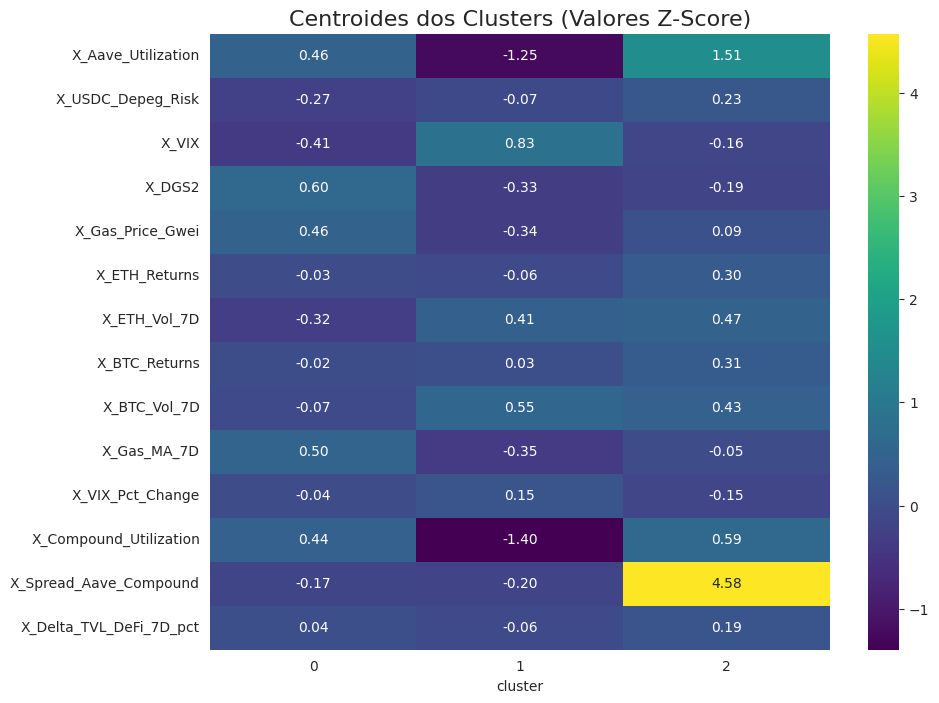

In [119]:
# Bloco 5: Análise dos Centroides (O que cada cluster significa?)

# Criar um dataframe de análise com os dados de treino padronizados
X_train_analysis = X_train_scaled.copy()
X_train_analysis['cluster'] = train_regimes

# Agrupar por cluster e calcular a média (centroides)
# Usamos os dados padronizados (X_train_scaled) para a análise,
# pois as médias dos dados brutos teriam escalas diferentes.
cluster_centers = X_train_analysis.groupby('cluster').mean().T

print("\n--- Análise dos Centroides (Média das features Z-score por cluster) ---")
print(cluster_centers)

# Plotar um heatmap para visualizar facilmente
plt.figure(figsize=(10, 8))
sns.heatmap(cluster_centers, annot=True, cmap='viridis', fmt='.2f')
plt.title('Centroides dos Clusters (Valores Z-Score)', fontsize=16)
plt.plot()
print("\nHeatmap dos centroides salvo como 'cluster_centroids_heatmap.png'")

Plotando áreas dos regimes (axvspan)...
Gráfico de regimes salvo como 'spread_com_regimes_kmeans.png'


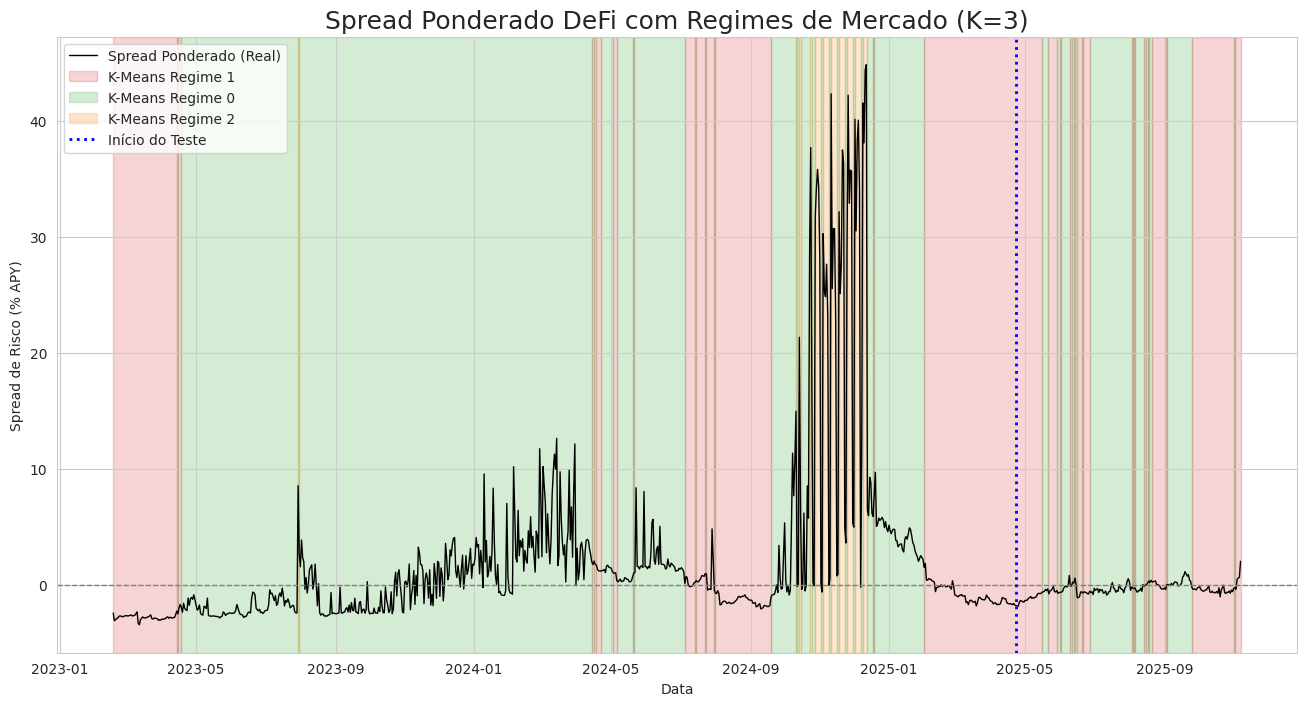

In [120]:
# Bloco 6: Visualização dos Regimes de Mercado (axvspan plot)

# 1. Juntar treino e teste para plotagem contínua
df_plot = pd.concat([df_train, df_test])

# 2. Configurações de Plotagem
plt.figure(figsize=(16, 8))
# Usamos nosso NOVO alvo ponderado
target_plot_column = 'Y_Target_Spread_Ponderado'
# Cores para 3 clusters
colors = ['#2ca02c', '#d62728', '#ff7f0e'] # Verde, Vermelho, Laranja
regime_names = [f'K-Means Regime {i}' for i in range(N_CLUSTERS)]

# 3. Plotar a linha do Spread
ax = sns.lineplot(data=df_plot, x=df_plot.index, y=target_plot_column, 
                  label='Spread Ponderado (Real)', color='black', linewidth=1.0)
ax.axhline(0, ls='--', color='grey', lw=1)

# 4. Loop para colorir o fundo (axvspan) - Lógica do seu notebook
print("Plotando áreas dos regimes (axvspan)...")
plotted_labels = set()
start_date = df_plot.index[0]
current_regime = df_plot.iloc[0]['cluster']

for i in range(1, len(df_plot)):
    row = df_plot.iloc[i]
    if row['cluster'] != current_regime:
        end_date = df_plot.index[i]
        label = regime_names[int(current_regime)] if regime_names[int(current_regime)] not in plotted_labels else None
        
        ax.axvspan(start_date, end_date, color=colors[int(current_regime)], 
                   alpha=0.2, label=label, zorder=0)
        
        plotted_labels.add(regime_names[int(current_regime)])
        start_date = end_date
        current_regime = row['cluster']

# Plotar o último bloco
label = regime_names[int(current_regime)] if regime_names[int(current_regime)] not in plotted_labels else None
ax.axvspan(start_date, df_plot.index[-1], color=colors[int(current_regime)], 
           alpha=0.2, label=label, zorder=0)

# 5. Linha de Divisão Treino/Teste
split_date = df_test.index[0]
ax.axvline(split_date, color='blue', linestyle=':', linewidth=2, label='Início do Teste')

# 6. Finalizar o Gráfico
ax.legend(loc='upper left')
plt.title(f'Spread Ponderado DeFi com Regimes de Mercado (K={N_CLUSTERS})', fontsize=18)
plt.ylabel('Spread de Risco (% APY)')
plt.xlabel('Data')
plt.plot()
print("Gráfico de regimes salvo como 'spread_com_regimes_kmeans.png'")
plt.show()

# recomeço

In [121]:
# Bloco [153] (CORRIGIDO)

# --- 1. Carregar Dados ---
# (Seu código original aqui, carregando 'dataset_para_modelagem.csv')

# --- 2. Engenharia de Features (Adição de Lags do ALVO) ---
TARGET_COLUMN = 'Y_Target_Spread_Ponderado'
df['X_Lag_1D'] = df[TARGET_COLUMN].shift(1)
df['X_Lag_3D'] = df[TARGET_COLUMN].shift(3)
df['X_Lag_7D'] = df[TARGET_COLUMN].shift(7)
# Note: df_model = df.dropna() é movido para o final

# --- 3. Seleção de Features (Definindo X_cluster e X_regress) ---
# features_cluster são as features do dia 't' que usamos para o K-Means
features_cluster_t = [
    'X_Aave_Utilization', 'X_USDC_Depeg_Risk', 'X_VIX', 'X_DGS2', 
    'X_Gas_Price_Gwei', 'X_ETH_Returns', 'X_ETH_Vol_7D', 'X_BTC_Returns', 
    'X_BTC_Vol_7D', 'X_Gas_MA_7D', 'X_VIX_Pct_Change',
    'X_Compound_Utilization', 'X_Spread_Aave_Compound', 'X_Delta_TVL_DeFi_7D_pct'
]
features_cluster_t = [f for f in features_cluster_t if f in df.columns]

# features_regress serão os lags (t-1) de todas as nossas features
features_regress_lagged_names = []
features_regress_lagged_names.extend(['X_Lag_1D', 'X_Lag_3D', 'X_Lag_7D']) # Lags do alvo

# --- 4. APLICAÇÃO DA CORREÇÃO (Criando Lags das Features) ---
print("Corrigindo Data Leakage: Criando lags (t-1) para features de regressão...")

for col in features_cluster_t:
    lag_name = f'{col}_Lag1' # ex: 'X_Aave_Utilization_Lag1'
    df[lag_name] = df[col].shift(1)
    features_regress_lagged_names.append(lag_name) # Adiciona o nome da feature defasada

# --- 5. Limpeza e Separação Final ---
# Agora o dropna() remove NaNs dos lags do alvo E das features
df_model = df.dropna().copy() # .copy() evita SettingWithCopyWarning

# y é o Alvo(t)
y = df_model[TARGET_COLUMN]

# X_regress agora contém APENAS dados de (t-1) ou anterior
X_regress = df_model[features_regress_lagged_names]

# X_cluster (para K-Means) agora usará os dados defasados (t-1)
# Vamos criar a lista de nomes das features de cluster defasadas:
features_cluster_lagged_names = [f'{col}_Lag1' for col in features_cluster_t]

# X_cluster agora é um SUBCONJUNTO do X_regress (só dados t-1)
X_cluster = X_regress[features_cluster_lagged_names] # <--- CORREÇÃO AQUI

print("Features de regressão (X_regress) e cluster (X_cluster) agora usam apenas dados defasados.")

# --- 6. Padronização e Divisão (O resto do seu código) ---
# Padroniza X_cluster(t-1) para o K-Means
scaler = StandardScaler()
X_cluster_scaled = scaler.fit_transform(X_cluster) # <--- CORREÇÃO AQUI
X_cluster_scaled = pd.DataFrame(X_cluster_scaled, columns=X_cluster.columns, index=X_cluster.index)

# --- 4. Divisão Treino/Teste ---
split_index = int(len(df_model) * 0.8)

# X_cluster_train/test AGORA são dados (t-1)
X_cluster_train = X_cluster_scaled.iloc[:split_index]
X_cluster_test = X_cluster_scaled.iloc[split_index:]
X_regress_train = X_regress.iloc[:split_index]
X_regress_test = X_regress.iloc[split_index:]
y_train = y.iloc[:split_index]
y_test = y.iloc[split_index:]
df_train = df_model.iloc[:split_index].copy()
df_test = df_model.iloc[split_index:].copy()

# --- 5. Clusterização (K=3) ---
N_CLUSTERS = 3
kmeans = KMeans(n_clusters=N_CLUSTERS, random_state=42, n_init=10)
train_regimes = kmeans.fit_predict(X_cluster_train)
test_regimes = kmeans.predict(X_cluster_test)
df_train = df_train.assign(cluster=train_regimes)
df_test = df_test.assign(cluster=test_regimes)


Corrigindo Data Leakage: Criando lags (t-1) para features de regressão...
Features de regressão (X_regress) e cluster (X_cluster) agora usam apenas dados defasados.


In [122]:

# --- 6. Modelagem (Treino por Cluster para AMBOS os modelos) ---

# --- 6. Modelagem (COM HYPERPARAMETER TUNING) ---

# --- Definir o Grid de Parâmetros para o RF ---
# Esta é uma grade de exemplo. Podemos ajustar isso.
param_grid_rf = {
    'n_estimators': [100, 200],
    'max_depth': [2, 3, 5, 10, None],          # Profundidade da árvore
    'min_samples_leaf': [1, 2, 5],         # Mínimo de amostras por folha
    'max_features': ['sqrt', 0.8]     # Quantidade de features por árvore
}

models_by_cluster_lasso = {} # Mantendo o Lasso para comparação
models_by_cluster_rf = {}

print("\n" + "="*50)
print("--- Treinando Modelos RF com GridSearchCV por Cluster ---")

# --- Validação Cruzada para Séries Temporais ---
# Usaremos 3 splits para o CV.
tscv = TimeSeriesSplit(n_splits=3)

for cluster_id in range(N_CLUSTERS):
    X_train_cluster = X_regress_train[df_train['cluster'] == cluster_id]
    y_train_cluster = y_train[df_train['cluster'] == cluster_id]
    
    # Precisamos de dados suficientes para o TimeSeriesSplit (n_splits + 1)
    if len(X_train_cluster) < 20: 
        print(f"\nCluster {cluster_id}: Pulando (poucos dados de treino).")
        models_by_cluster_lasso[cluster_id] = None
        models_by_cluster_rf[cluster_id] = None
        continue
    
    print(f"\nCluster {cluster_id}: Iniciando GridSearchCV (Lasso)...")
    
    # --- Modelo 1: LassoCV (Linear) ---
    # O LassoCV já faz tuning do 'alpha' por padrão
    model_lasso = LassoCV(cv=tscv, random_state=42, max_iter=3000, n_jobs=-1)
    model_lasso.fit(X_train_cluster, y_train_cluster)
    models_by_cluster_lasso[cluster_id] = model_lasso

    print(f"Cluster {cluster_id}: Iniciando GridSearchCV (RandomForest)...")
    
    # --- Modelo 2: RandomForest com GridSearchCV ---
    rf = RandomForestRegressor(random_state=42, n_jobs=-1)
    
    grid_search_rf = GridSearchCV(
        estimator=rf, 
        param_grid=param_grid_rf, 
        cv=tscv,        # Usando o TimeSeriesSplit
        n_jobs=-1,      # Usar todos os processadores
        scoring= 'neg_root_mean_squared_error',   # Otimizar para R² 
        verbose=1       # Para vermos o progresso
    ) 
    
    grid_search_rf.fit(X_train_cluster, y_train_cluster) 
    
    # Salvar o *melhor* modelo encontrado pelo GridSearch
    models_by_cluster_rf[cluster_id] = grid_search_rf.best_estimator_ 
    
    print(f"Cluster {cluster_id} (RF): Melhor R² (treino-cv): {grid_search_rf.best_score_:.4f}")
    print(f"Cluster {cluster_id} (RF): Melhores Parâmetros: {grid_search_rf.best_params_}")

print("\n--- Treinamento Concluído ---")


--- Treinando Modelos RF com GridSearchCV por Cluster ---

Cluster 0: Iniciando GridSearchCV (Lasso)...
Cluster 0: Iniciando GridSearchCV (RandomForest)...
Fitting 3 folds for each of 60 candidates, totalling 180 fits


Cluster 0 (RF): Melhor R² (treino-cv): -4.2477
Cluster 0 (RF): Melhores Parâmetros: {'max_depth': None, 'max_features': 0.8, 'min_samples_leaf': 1, 'n_estimators': 200}

Cluster 1: Iniciando GridSearchCV (Lasso)...
Cluster 1: Iniciando GridSearchCV (RandomForest)...
Fitting 3 folds for each of 60 candidates, totalling 180 fits
Cluster 1 (RF): Melhor R² (treino-cv): -12.3465
Cluster 1 (RF): Melhores Parâmetros: {'max_depth': 10, 'max_features': 0.8, 'min_samples_leaf': 5, 'n_estimators': 200}

Cluster 2: Iniciando GridSearchCV (Lasso)...
Cluster 2: Iniciando GridSearchCV (RandomForest)...
Fitting 3 folds for each of 60 candidates, totalling 180 fits
Cluster 2 (RF): Melhor R² (treino-cv): -1.2729
Cluster 2 (RF): Melhores Parâmetros: {'max_depth': 5, 'max_features': 0.8, 'min_samples_leaf': 2, 'n_estimators': 200}

--- Treinamento Concluído ---


In [123]:

# --- 7. Geração de Predições (Para AMBOS os modelos) ---
"""predictions_lasso = pd.Series(index=X_regress_test.index, dtype=float, name="predicted_lasso")
for cluster_id, model in models_by_cluster_lasso.items():
    if model is None: continue
    if cluster_id not in df_test['cluster'].values: continue
    X_test_cluster = X_regress_test[df_test['cluster'] == cluster_id]
    if not X_test_cluster.empty:
        preds_cluster = model.predict(X_test_cluster)
        predictions_lasso.loc[X_test_cluster.index] = preds_cluster

predictions_rf = pd.Series(index=X_regress_test.index, dtype=float, name="predicted_rf")
for cluster_id, model in models_by_cluster_rf.items():
    if model is None: continue
    if cluster_id not in df_test['cluster'].values: continue
    X_test_cluster = X_regress_test[df_test['cluster'] == cluster_id]
    if not X_test_cluster.empty:
        preds_cluster = model.predict(X_test_cluster)
        predictions_rf.loc[X_test_cluster.index] = preds_cluster
        
# --- 8. ANÁLISE DETALHADA (Apenas RandomForest - Conforme Solicitado) ---
print("\n" + "="*50)
print("--- Performance de TESTE Detalhada por Cluster (Modelo RandomForest) ---")

results_rf = pd.DataFrame({'actual': y_test, 'predicted': predictions_rf})
results_rf = results_rf.join(df_test['cluster']).dropna()"""


# --- 7. GERAÇÃO DE PREDIÇÕES (Abordagem Híbrida RF + Lasso) ---
print("\nGerando predições no conjunto de teste (Híbrido RF/Lasso)...")

predictions_rf_final = pd.Series(index=X_regress_test.index, dtype=float, name="predicted_rf_hybrid")

# --- Cluster 0: Aplicar Modelo Lasso (Simples) ---
cluster_id_0 = 0
model_lasso_0 = models_by_cluster_lasso[cluster_id_0]

if model_lasso_0 is not None and cluster_id_0 in df_test['cluster'].values:
    X_test_cluster_0 = X_regress_test[df_test['cluster'] == cluster_id_0]
    if not X_test_cluster_0.empty:
        preds_cluster_0_lasso = model_lasso_0.predict(X_test_cluster_0)
        predictions_rf_final.loc[X_test_cluster_0.index] = preds_cluster_0_lasso
        print("Cluster 0: Aplicando predição do Lasso (Modelo Linear).")

# --- Cluster 1: Pular (se houver) ---
cluster_id_1 = 1
# (Nada a fazer, 0 pontos no teste)

# --- Cluster 2: Aplicar Modelo RandomForest Otimizado (Não-Linear) ---
cluster_id_2 = 2
model_rf_2 = models_by_cluster_rf[cluster_id_2]

if model_rf_2 is not None and cluster_id_2 in df_test['cluster'].values:
    X_test_cluster_2 = X_regress_test[df_test['cluster'] == cluster_id_2]
    if not X_test_cluster_2.empty:
        preds_cluster_2_rf = model_rf_2.predict(X_test_cluster_2)
        predictions_rf_final.loc[X_test_cluster_2.index] = preds_cluster_2_rf
        print("Cluster 2: Aplicando modelo RF otimizado (GridSearch).")

# --- 8. ANÁLISE DETALHADA ---
# (Certifique-se de que a análise e o plot usem a nova 'predictions_rf_final')
print("\n" + "="*50)
print("--- Performance de TESTE Detalhada (Modelo Híbrido RF/Lasso) ---")

# Criar o DataFrame de resultados com as predições híbridas
results_rf = pd.DataFrame({'actual': y_test, 'predicted': predictions_rf_final})
results_rf = results_rf.join(df_test['cluster']).dropna()

# ... (o resto da sua célula [197] para análise e plotagem permanece igual) ...




cluster_performance = []
r2_scores = {} # Dicionário para guardar R² para o gráfico

if results_rf.empty:
    print("Nenhuma predição válida gerada para o RandomForest.")
    r2_scores['rf'] = np.nan
else:
    for cluster_id in range(N_CLUSTERS):
        cluster_df = results_rf[results_rf['cluster'] == cluster_id]
        count = len(cluster_df)
        
        if count < 2:
            mae, r2, rmse = np.nan, np.nan, np.nan
        else:
            mae = mean_absolute_error(cluster_df['actual'], cluster_df['predicted'])
            r2 = r2_score(cluster_df['actual'], cluster_df['predicted'])
            mse = mean_squared_error(cluster_df['actual'], cluster_df['predicted'])
            rmse = np.sqrt(mse) 
            
        cluster_performance.append({
            'Cluster': cluster_id,
            'Pontos_no_Teste': count,
            'MAE': mae,
            'R2': r2,
            'RMSE': rmse
        })

    performance_df = pd.DataFrame(cluster_performance).set_index('Cluster')
    print("--- Tabela Resumo da Performance (Conjunto de Teste - RF) ---")
    print(performance_df.to_markdown(floatfmt=".4f"))
    print("="*50)

    mae_global = mean_absolute_error(results_rf['actual'], results_rf['predicted'])
    r2_global = r2_score(results_rf['actual'], results_rf['predicted'])
    mse_global = mean_squared_error(results_rf['actual'], results_rf['predicted'])
    rmse_global = np.sqrt(mse_global)

    print(f"\nMAE Global (RF): {mae_global:.4f}")
    print(f"R² Global (RF):  {r2_global:.4f}")
    print(f"RMSE Global (RF): {rmse_global:.4f}")
    
    r2_scores['rf'] = r2_global
"""
# --- 9. Cálculo R² Lasso (Silencioso, apenas para o gráfico) ---
results_lasso = pd.DataFrame({'actual': y_test, 'predicted': predictions_lasso}).dropna()
if results_lasso.empty:
    r2_scores['lasso'] = np.nan
else:
    r2_scores['lasso'] = r2_score(results_lasso['actual'], results_lasso['predicted'])

# --- 10. Plotar Comparação Final (Conforme Código 2) ---
plt.figure(figsize=(14, 7))
plt.plot(y_test, label='Real', color='black', linewidth=1.5)

if not predictions_lasso.dropna().empty:
    plt.plot(predictions_lasso, label=f'Lasso (R²: {r2_scores["lasso"]:.3f})', linestyle='--', linewidth=2)

if not predictions_rf.dropna().empty:
    plt.plot(predictions_rf, label=f'Random Forest (R²: {r2_scores["rf"]:.3f})', linestyle=':', linewidth=2)

plt.title(f'Predição vs. Real (Modelos com Lags por Cluster)', fontsize=16)
plt.ylabel(TARGET_COLUMN)
plt.legend()
plt.grid(True, linestyle=':', alpha=0.6)
plt.show()"""


Gerando predições no conjunto de teste (Híbrido RF/Lasso)...
Cluster 0: Aplicando predição do Lasso (Modelo Linear).
Cluster 2: Aplicando modelo RF otimizado (GridSearch).

--- Performance de TESTE Detalhada (Modelo Híbrido RF/Lasso) ---
--- Tabela Resumo da Performance (Conjunto de Teste - RF) ---
|   Cluster |   Pontos_no_Teste |      MAE |       R2 |     RMSE |
|----------:|------------------:|---------:|---------:|---------:|
|         0 |           96.0000 |   0.6669 |  -1.8568 |   0.7512 |
|         1 |            0.0000 | nan      | nan      | nan      |
|         2 |          103.0000 |   0.2354 |   0.7329 |   0.2918 |

MAE Global (RF): 0.4436
R² Global (RF):  -0.0830
RMSE Global (RF): 0.5624


'\n# --- 9. Cálculo R² Lasso (Silencioso, apenas para o gráfico) ---\nresults_lasso = pd.DataFrame({\'actual\': y_test, \'predicted\': predictions_lasso}).dropna()\nif results_lasso.empty:\n    r2_scores[\'lasso\'] = np.nan\nelse:\n    r2_scores[\'lasso\'] = r2_score(results_lasso[\'actual\'], results_lasso[\'predicted\'])\n\n# --- 10. Plotar Comparação Final (Conforme Código 2) ---\nplt.figure(figsize=(14, 7))\nplt.plot(y_test, label=\'Real\', color=\'black\', linewidth=1.5)\n\nif not predictions_lasso.dropna().empty:\n    plt.plot(predictions_lasso, label=f\'Lasso (R²: {r2_scores["lasso"]:.3f})\', linestyle=\'--\', linewidth=2)\n\nif not predictions_rf.dropna().empty:\n    plt.plot(predictions_rf, label=f\'Random Forest (R²: {r2_scores["rf"]:.3f})\', linestyle=\':\', linewidth=2)\n\nplt.title(f\'Predição vs. Real (Modelos com Lags por Cluster)\', fontsize=16)\nplt.ylabel(TARGET_COLUMN)\nplt.legend()\nplt.grid(True, linestyle=\':\', alpha=0.6)\nplt.show()'

In [124]:
# Bloco Final: Interpretação dos Modelos

print("--- Importância das Features (Modelos RandomForest) ---")

# Loop pelos modelos RF
for cluster_id, model in models_by_cluster_rf.items():
    if model is None: continue # Pular se o modelo não foi treinado
        
    print(f"\n--- Cluster {cluster_id} (RandomForest) ---")
    
    # Criar um DataFrame de importância das features
    importances = pd.DataFrame(
        data=model.feature_importances_, 
        index=X_regress_train.columns,  # Usar colunas do X_regress
        columns=['Importance']
    ).sort_values(by='Importance', ascending=False)
    
    # !!! MUDANÇA AQUI: Usar .to_string() para evitar truncamento !!!
    # Adicionado float_format para melhor legibilidade
    print(importances.head(5).to_string(float_format="%.5f"))

print("\n" + "="*30 + "\n")

print("--- Coeficientes (Modelos Lasso) ---")
# Loop pelos modelos Lasso
for cluster_id, model in models_by_cluster_lasso.items():
    if model is None: continue # Pular se o modelo não foi treinado
        
    print(f"\n--- Cluster {cluster_id} (Lasso) ---")
    
    # Criar um DataFrame de coeficientes
    coefs = pd.DataFrame(
        data=model.coef_, 
        index=X_regress_train.columns, # Usar colunas do X_regress
        columns=['Coefficient']
    )
    
    # Filtra coeficientes que não são zero
    coefs_nonzero = coefs[coefs['Coefficient'] != 0]
    
    if coefs_nonzero.empty:
        print("Nenhum coeficiente diferente de zero neste cluster.")
        continue
        
    # Ordena pelo valor absoluto
    coefs_sorted = coefs_nonzero.reindex(coefs_nonzero['Coefficient'].abs().sort_values(ascending=False).index)
    
    # !!! MUDANÇA AQUI: Usar .to_string() para evitar truncamento !!!
    # Adicionado float_format para melhor legibilidade
    print(coefs_sorted.head(5).to_string(float_format="%.5f"))

print("\n" + "="*30)

--- Importância das Features (Modelos RandomForest) ---

--- Cluster 0 (RandomForest) ---
                         Importance
X_Lag_7D                    0.38051
X_Lag_1D                    0.18181
X_Lag_3D                    0.17575
X_Aave_Utilization_Lag1     0.03020
X_VIX_Lag1                  0.02792

--- Cluster 1 (RandomForest) ---
                             Importance
X_Lag_7D                        0.65030
X_Spread_Aave_Compound_Lag1     0.08509
X_Lag_1D                        0.04342
X_DGS2_Lag1                     0.03718
X_BTC_Returns_Lag1              0.02834

--- Cluster 2 (RandomForest) ---
                             Importance
X_Lag_1D                        0.59808
X_Lag_3D                        0.21308
X_Lag_7D                        0.04589
X_Aave_Utilization_Lag1         0.04435
X_Compound_Utilization_Lag1     0.03344


--- Coeficientes (Modelos Lasso) ---

--- Cluster 0 (Lasso) ---
                             Coefficient
X_DGS2_Lag1                     -0.5369

In [125]:
import torch
import pytorch_lightning as pl
from pytorch_forecasting import TimeSeriesDataSet, TemporalFusionTransformer
from pytorch_forecasting.data import GroupNormalizer
from pytorch_forecasting.metrics import MAE, SMAPE, RMSE
from pytorch_lightning.callbacks import EarlyStopping

# --- 1. Filtrar os dados de TREINO para o Cluster 0 ---
# Usamos df_train (criado na sua célula [107]/[153]) que já contém os 'clusters'
# IMPORTANTE: Estamos usando as features defasadas (Lag1) que você criou no Bloco [153]
df_train_cluster_0 = df_train[df_train['cluster'] == 0].copy()

# --- 2. Criar Colunas Obrigatórias para o TFT ---

# a. time_idx: um índice de tempo INTEIRO contínuo
# Vamos normalizar o índice de tempo (dias desde o início)
df_train_cluster_0['time_idx'] = (df_train_cluster_0.index - df_model.index.min()).days

# b. group_id: Como só temos UMA série temporal (o mercado), criamos um grupo "dummy"
df_train_cluster_0['group_id'] = "cluster_0" # ID do grupo

# c. target: Nosso novo alvo (a DIFERENÇA do spread)
#TARGET_COLUMN = 'Y_Target_Spread_Diff_1D' 

# --- 3. Definir Nossas Features ---
# Features que mudam com o tempo e NÃO são conhecidas no futuro 
# (Usamos as features defasadas '..._Lag1' do seu Bloco [153])
features_tft = [
    'X_Aave_Utilization_Lag1', 'X_USDC_Depeg_Risk_Lag1', 'X_VIX_Lag1', 'X_DGS2_Lag1', 
    'X_Gas_Price_Gwei_Lag1', 'X_ETH_Returns_Lag1', 'X_ETH_Vol_7D_Lag1', 'X_BTC_Returns_Lag1', 
    'X_BTC_Vol_7D_Lag1', 'X_Gas_MA_7D_Lag1', 'X_VIX_Pct_Change_Lag1',
    'X_Compound_Utilization_Lag1', 'X_Spread_Aave_Compound_Lag1', 'X_Delta_TVL_DeFi_7D_pct_Lag1',
    
    # Lags do alvo (nível) são ótimas features
    'X_Lag_1D', 'X_Lag_3D', 'X_Lag_7D' 
]

# Garantir que todas as colunas existem
features_tft = [f for f in features_tft if f in df_train_cluster_0.columns]

print(f"Features usadas no TFT (todas defasadas): {len(features_tft)}")

Features usadas no TFT (todas defasadas): 17


/home/renzo/Documents/GitHub/6-datathon-fgv-eesp/datathon/lib/python3.12/site-packages/pytorch_forecasting/models/base/_base_model.py:28: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from tqdm.autonotebook import tqdm


In [126]:
# --- 4. Criar o TimeSeriesDataSet ---

max_encoder_length = 30  # Histórico: Usar os últimos 30 dias de dados como input
max_prediction_length = 7 # Horizonte: Tentar prever os próximos 7 dias

# Criar o dataset de TREINO (training_cutoff)
# Usamos 90% dos dados do Cluster 0 para treinar e 10% para validar o TFT
training_cutoff = df_train_cluster_0["time_idx"].max() - max_prediction_length

training_data = TimeSeriesDataSet(
    df_train_cluster_0[lambda x: x.time_idx <= training_cutoff],
    time_idx="time_idx",
    target=TARGET_COLUMN,
    group_ids=["group_id"],
    max_encoder_length=max_encoder_length,
    max_prediction_length=max_prediction_length,
    
    # IMPORTANTE: Se os dias do Cluster 0 não são contínuos (e não são!)
    allow_missing_timesteps=True, 
    
    # Nossas features defasadas (t-1)
    time_varying_unknown_reals=features_tft,
    
    # Normalização
    target_normalizer=GroupNormalizer(
        groups=["group_id"], transformation="softplus" # Usar softplus pois a diferença pode ser negativa
    ) 
)

# Criar o dataset de VALIDAÇÃO (para o TFT saber quando parar de treinar)
# Usamos o dataset de treino inteiro
validation_data = TimeSeriesDataSet.from_dataset(
    training_data, 
    df_train_cluster_0, 
    predict=True, 
    stop_randomization=True
)

print("TimeSeriesDataSet criado com sucesso.")

TimeSeriesDataSet criado com sucesso.


In [ ]:
# --- 5. Criar DataLoaders e Treinar o Modelo ---

batch_size = 16 # Ajuste conforme a memória do seu PC/Colab
train_dataloader = training_data.to_dataloader(
    train=True, batch_size=batch_size, num_workers=0
)
val_dataloader = validation_data.to_dataloader(
    train=False, batch_size=batch_size, num_workers=0
)

# Parar cedo se o modelo não melhorar
early_stop_callback = EarlyStopping(monitor="val_loss", min_delta=1e-4, patience=5, verbose=False, mode="min")

# Definir o trainer (use 'gpu' se tiver uma)
trainer = pl.Trainer(
    max_epochs=30, # Comece com 30 épocas
    accelerator="gpu", # Mude para "gpu" se disponível
    devices=1,
    gradient_clip_val=0.1,
    callbacks=[early_stop_callback],
)

# Instanciar o modelo TFT
tft = TemporalFusionTransformer.from_dataset(
    training_data,
    learning_rate=0.01, # Taxa de aprendizado
    hidden_size=32,         # Tamanho das camadas ocultas
    attention_head_size=2,  # Número de cabeças de atenção
    dropout=0.2,            # Dropout para evitar overfitting
    hidden_continuous_size=16, # Tamanho da camada para features contínuas
    loss=RMSE(),            # Otimizar para RMSE
    optimizer="Ranger"      # Um otimizador robusto
)

print(f"Iniciando treinamento do TFT para o Cluster 0 (Alvo: {TARGET_COLUMN})...")

# Treinar!
trainer.fit(
    tft,
    train_dataloaders=train_dataloader,
    val_dataloaders=val_dataloader,
)

💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores


Iniciando treinamento do TFT para o Cluster 0 (Alvo: Y_Target_Spread_Ponderado)...


/home/renzo/Documents/GitHub/6-datathon-fgv-eesp/datathon/lib/python3.12/site-packages/lightning/pytorch/utilities/parsing.py:210: Attribute 'loss' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['loss'])`.
/home/renzo/Documents/GitHub/6-datathon-fgv-eesp/datathon/lib/python3.12/site-packages/lightning/pytorch/utilities/parsing.py:210: Attribute 'logging_metrics' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['logging_metrics'])`.


TypeError: `model` must be a `LightningModule` or `torch._dynamo.OptimizedModule`, got `TemporalFusionTransformer`